In [ ]:
""" Copyright (c) 2023, ETH Zurich, 
Alexandre Didier*, Robin C. Jacobs*, Jerome Sieber*, Kim P. Wabersich°, Prof. Dr. Melanie N. Zeilinger*, 
*Institute for Dynamic Systems and Control, D-MAVT
°Corporate Research of Robert Bosch GmbH
All rights reserved."""

In [1]:
import torch
import numpy as np
from casadi import *
import cvxpy as cp
from tqdm.notebook import tqdm
from torch import nn
from pytope import Polytope
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
import time
from multiprocessing import Pool
import os

from apcbf.approximator import *
from apcbf.controller import *
import apcbf.simulation as sim
from apcbf.dynamic import *
from apcbf.controller import *
from apcbf.nn_model_types import NonLinModelType
from apcbf.non_lin_sys import *
from apcbf.approximate_pcbf_nonlinear import *

In [2]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)
constraint_color = (0, 120.0/256, 148.0/256)

In [3]:
def output_modifier(h) :
    return np.exp(h) - 1

In [4]:
sys = non_lin_disc
print(sys)
sys.input_dim

NonlinearDiscreteDynamics(
 f: <method-wrapper '__str__' of function object at 0x7f5e593d8ca0>


2

In [5]:
N = 20
c = 0.001
mu_x = np.sqrt(0.001)
mu_u = np.sqrt(0.001)

alpha_f = 1000 # Need to check if Df\int(X_{N-1}(0)) not empty then can choose alpha_f arbitrary large
delta_i = lambda i : i*0.005 #as done in example

### Load Parameters

In [6]:
# load parameters values
params_dict = pickle.load(open( "../params/non_linear_termset_params.p", "rb" ))
params_dict

{'P_f': array([[ 1.05097272e+00,  5.47383181e+00,  2.80315280e+00,
         -8.55535683e-20],
        [ 5.47383181e+00,  3.16255265e+01,  1.67387432e+01,
         -5.12263033e-19],
        [ 2.80315280e+00,  1.67387432e+01,  9.36896767e+00,
         -2.92917364e-19],
        [-8.55535683e-20, -5.12263033e-19, -2.92917364e-19,
          2.05617580e-01]]),
 'K_f': array([[-3.58269824e-02, -1.66596318e+00, -1.83800159e+00,
         -3.76529061e-20],
        [ 1.14231034e-18,  6.21150136e-18,  3.17977562e-18,
         -9.06901475e-01]]),
 'gamma_x': 0.009936271172834462,
 'gamma_f': 0.9900637288271655,
 'alpha_f': 1000,
 'T_disc': 0.05}

Constraints

In [7]:
constraint_dict = pickle.load(open("../params/non_linear_constraints_params.p", 'rb'))
X = constraint_dict['X']
U = constraint_dict['U']

In [8]:
K = 10*np.ones((2,4))
bad_ctrl = LinearController(K)

## Generate Data

Note: Data generation step can be skipped by loading generated data points instead in the next section

In [ ]:
all_models = [1,2,3,4]
val_loss = [7.5593, 6.3329 , 2.7308865 , 0.6645 ] #computed separately from train_data_geom_sampl_thresh_100_127.441k_nonlinear_paper.pt
colors_ls = ['red', 'blue', 'orange', 'green', 'violet']
#marker_ls = [ '.', '^', 'o' , '*']

In [ ]:
#phis = np.linspace(-0.5, 0.5, 4)
phis = [0.1]
x0 = [4.0, 0, 0, 0]
N_steps = 10000
t = np.arange(N_steps+1)
#fig, axs = plt.subplots(1,1)



axs = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    A
    """
#     """
#     AAAB
#     AAAC
#     AAAD
#     """
)

x_safe_traj_list = []

len_m_list = len(all_models)
sel_idx_low, sel_idx_high = 0, N_steps
for i,model_n in enumerate(all_models):
    for phi in phis:
        x0[1] = phi
        #full_path = f'models/datasize_test/epoch_model_only/epoch_{i+1}.pt'
        if model_n == -1:
            full_path = '../models/model_nlup_NNplus_100_02_06_11_35.pt'
        else :
#             full_path = f'models/datasize_test/datasize/data_{model_n}.pt'
              full_path = f'../models/datasize_test/datasize/bs_{model_n}.pt'
        print(full_path)
        model_sel = torch.load(full_path, map_location=torch.device('cpu'))
        ctrl_kinf_new = APCBFSafetyFilterKINFDEC(model_sel, m_type=model_type, use_log_space_model=use_log_space_model, 
                                                             use_plus_model=use_plus_model, sys=sys, params_dict = params_dict,
                                                             input_constraints = U, performance_controller=bad_ctrl)

#         ctrl_kinf_new = APCBFSafetyFilterMAXDEC(model_sel, m_type=model_type, use_log_space_model=use_log_space_model, 
#                                                              use_plus_model=use_plus_model, sys=sys, params_dict = params_dict,
#                                                              input_constraints = U, performance_controller=bad_ctrl)

        x_safe, u_sim= sim.simulate_discrete(x0, sys, controller_object=ctrl_kinf_new, Nsteps=N_steps)
    
        axs["A"].plot(t[sel_idx_low:sel_idx_high],x_safe[sel_idx_low:sel_idx_high,0], color=colors_ls[i], label = '$e_{\mathrm{MSE}}=$'+f" {val_loss[i]:.3f}")
        #axs["B"].plot(t[sel_idx_low:sel_idx_high],x_safe[sel_idx_low:sel_idx_high,1], color=colors_ls[i], label = '$\Psi$')
        #axs["C"].plot(t[sel_idx_low:sel_idx_high],x_safe[sel_idx_low:sel_idx_high,2], color=colors_ls[i], label = '$\delta$')
        #axs["D"].plot(t[sel_idx_low:sel_idx_high],x_safe[sel_idx_low:sel_idx_high,3], color=colors_ls[i], label = '$v$')
        x_safe_traj_list.append(x_safe[sel_idx_low:sel_idx_high,0])
    
    y = np.zeros_like(t)  
axs["A"].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
#axs["B"].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='red', alpha=.1)
#axs["C"].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
#axs["D"].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)   
time_vec = t[sel_idx_low:sel_idx_high]

#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs["A"].legend()
#axs["B"].text(0.05, 0.95, '$\Psi$', transform=axs["B"].transAxes, fontsize=26,
#        verticalalignment='top')
#axs["C"].text(0.05, 0.95, '$\delta$', transform=axs["C"].transAxes, fontsize=26,
#        verticalalignment='top')
#axs["D"].text(0.05, 0.95, '$v$', transform=axs["D"].transAxes, fontsize=26,
#        verticalalignment='top')

#axs[0,0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='b', alpha=.1)
# axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='red', alpha=.1)
# axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
# axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)   

#axs[0,0].set_xlim([sel_idx_low, sel_idx_high])
#axs.set_ylim([-1, 2.5])
axs["A"].set_xlabel('time step $k$')
axs["A"].set_ylabel('$y_{\mathrm{off}}$')
#axs["B"].set_ylabel('$\Psi$')
#axs["B"].set_yticks([-2,2])
#axs["C"].set_ylabel('$\delta$')
#axs["D"].set_ylabel('$v$')
# axs["B"].set_xlabel('steps $k$')
# axs["C"].set_xlabel('steps $k$')
#axs["D"].set_xlabel('time step $k$')
#plt.title('Trajectory after x opt steps with batch size 128')
#plt.tight_layout()
#plt.savefig(f'plots/pdf/nonlinear_mse_analysis_steps_mutlimodel_{N_steps}_pts.pdf', bbox_inches='tight')

In [11]:
test_data = torch.load('../data/val_data_127k_nonlinear.pt')

In [ ]:
np.random.seed(1)
p = np.random.permutation(len(test_data.X))
X_test = test_data.X[p] 
y_test = test_data.y[p]

num_pts = 1000
X_test = X_test[:num_pts]
y_test = y_test[:num_pts] 

In [ ]:
test_data.X

In [ ]:
NEW_RUN = True
#plt.scatter(test_data.X[:,0], random_data.X[:,1])
#X_test = test_data.X[:1000,:]
#y_test = test_data.y[:1000]
Nsteps = 2000
phis = [0.1]
x0 = [4, 0, 0, 0]
t = np.arange(Nsteps+1)
fig, axs = plt.subplots(1,1)
len_m_list = len(all_models)
sel_idx_low, sel_idx_high = 0, 400

#val_loss = [1,2,3,4,5,6] # TODO change

if NEW_RUN:
    dist_val_all = []
    mean_distance_list = []
    plot_list = []
    std_dev_list = []
    
    
    

def sim_and_compute_distance(x):                
    x_safe, u_safe = sim.simulate_discrete(x, non_lin_disc, controller_object=ctrl_kinf_new, Nsteps=Nsteps, verbose=False)

    xs = cp.Variable((4,1))
    objective = cp.Minimize(cp.norm(xs - x_safe[-1,:].reshape(4,1)))
    constraints = [X.A @ xs <= X.b]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    #dist_val = np.append(dist_val, problem.value)
    return problem.value
    #plt.scatter(val_loss[i], problem.value)

    


for i,model_n in enumerate(all_models):
    for phi in phis:
        x0[1] = phi
        #full_path = f'models/datasize_test/epoch_model_only/epoch_{i+1}.pt'
        if model_n == -1:
            full_path = '../models/model_nlup_NNplus_100_02_06_11_35.pt'
        else :
#             full_path = f'models/datasize_test/datasize/data_{model_n}.pt'
              full_path = f'../models/l1_comparison/model_l1_{model_n}.pt'
        print(full_path)
        model_sel = torch.load(full_path, map_location=torch.device('cpu'))
        ctrl_kinf_new = LearnedCBFSafetyFilterControllerTorchKINFDEC(model_sel, m_type=model_type, use_log_space_model=use_log_space_model, 
                                                             use_plus_model=use_plus_model, sys=sys, params_dict = params_dict,
                                                             input_constraints = U, performance_controller=bad_ctrl)
        

        if NEW_RUN:
            dist_val = np.array([])
            pool = Pool(8)
            dist_val = []
            for result in tqdm.tqdm(pool.imap_unordered(sim_and_compute_distance, X_test), total=num_pts):
                 dist_val.append(result)
            #dist_val = pool.map(sim_and_compute_distance, X_test)
            dist_val = np.array(dist_val)
            dist_val_all.append(dist_val) 
        else:
            dist_val = dist_val_all[i]
        
        #print(dist_val)
        mean_distance = dist_val.mean()
        std_dev = dist_val.std()
        std_dev_list.append(std_dev)

        mean_distance_list.append(mean_distance)
#         dist_list.append(distance_to_constraint_boundary)
#         std_dev_list.append(std_dev)
        error = val_loss[i]
        print(error)
#         plot_list.append((error, mean_distance, dist_val))
#         plt.scatter(error*np.ones_like(dist_val), dist_val, color=colors_ls[i], label='$e_{\mathrm{MSE}}=$'+f" {val_loss[i]:.3f}")
#         plt.scatter(error, mean_distance, color='black', zorder=100)
#         plt.errorbar(error, mean_distance, std_dev, color=colors_ls[i],  capsize=20)
        
plt.plot(val_loss[:len(mean_distance_list)], mean_distance_list[:len(mean_distance_list)], color='black', zorder=100)
#plt.ylim([0,10])
#plt.yscale('log')
plt.legend()
plt.xlabel('$e_{\mathrm{MSE}}$')
plt.ylabel('$|x(400)|_\mathcal{X}$')
#plt.grid()
plt.tight_layout()
#plt.savefig(f'plots/pdf/nonlinear_mse_analysis_log_distance_to_state_constraint_k={N_steps}_pts={num_pts}.pdf', bbox_inches='tight')

## Restore generated data

In [10]:
import pickle

In [11]:
with open('../data/l1_comparison/plot_l1_analysis_mean_distance_list', 'rb') as f:
    mean_distance_list= pickle.load(f)

with open('../data/l1_comparison/plot_l1_analysis_distance__val_all', 'rb') as f:
    dist_val_all= pickle.load(f)
    
with open('../data/l1_comparison/plot_l1_analysis_stddev_list', 'rb') as f:
    std_dev_list = pickle.load(f)
    
with open('../data/l1_comparison/plot_l1_analysis_state_traj_list', 'rb') as f:
    x_safe_traj_list = pickle.load(f)
time_vec = np.arange(len(x_safe_traj_list[0]))

all_models = [500, 710, 2000, 10000]#, 40000] old:600 instead of 750
val_loss = [0.488, 0.294 , 0.160,  0.011]#, 0.002] , old : 0.280
colors_ls = ['red', 'blue', 'orange', 'green', 'violet']

## Joint plots

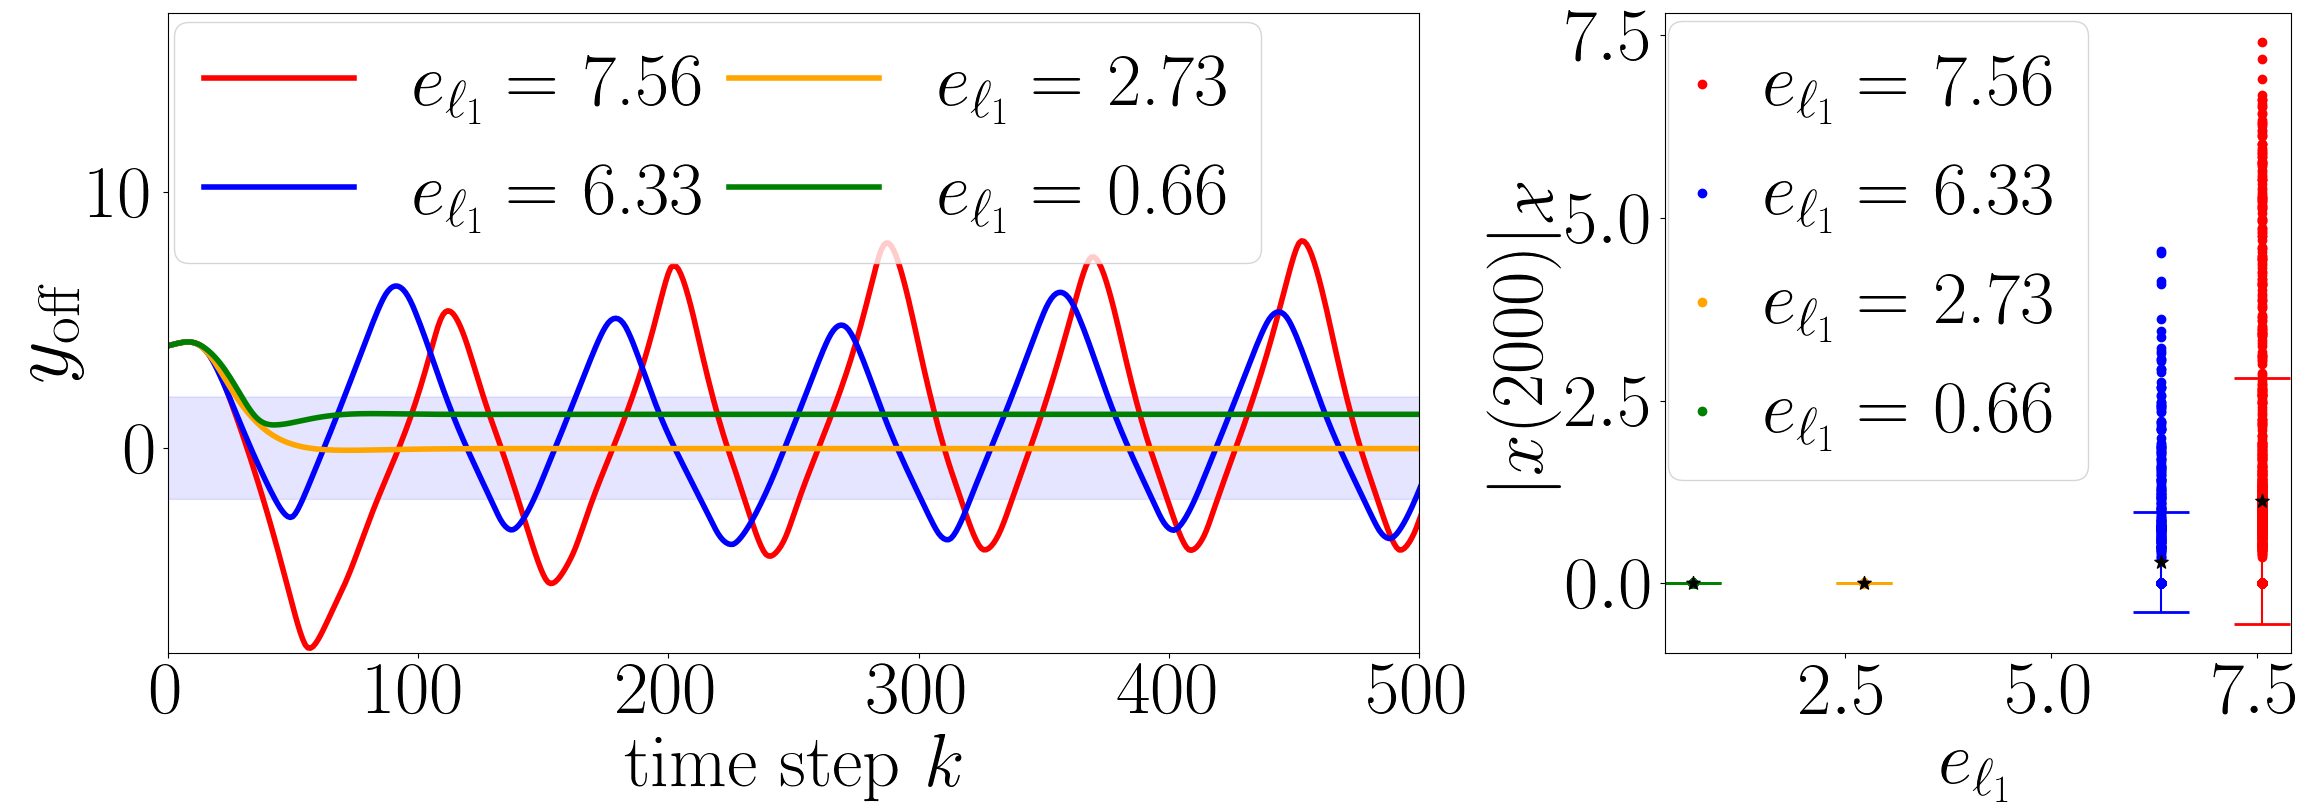

In [69]:
plt.rcParams['figure.figsize'] = [23, 8]
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 54})
plt.rc('text', usetex=True)
constraint_color = (0, 120.0/256, 148.0/256)
val_loss = [7.5593, 6.3329 , 2.7308865 , 0.6645 ] #computed separately from train_data_geom_sampl_thresh_100_127.441k_nonlinear_paper.pt
axs = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAB
    """
#     """
#     AAAB
#     AAAC
#     AAAD
#     """
)
#fig, ax = plt.subplots(2,1)
for i, error in enumerate(val_loss):
    axs["A"].plot(time_vec,x_safe_traj_list[i], color=colors_ls[i], label = '$e_{\ell_{1}}=$'+f" {error:.2f}", linewidth=4)

    y = np.zeros_like(time_vec)  
    
    
    axs["B"].scatter(error*np.ones_like(dist_val_all[i]), dist_val_all[i], color=colors_ls[i], label='$e_{\ell_{1}}=$'+f" {error:.2f}")
    axs["B"].scatter(error, mean_distance_list[i], color='black', marker="*", s=100, zorder=100)
    axs["B"].errorbar(error,mean_distance_list[i], std_dev_list[i], color=colors_ls[i],  capsize=20, markeredgewidth=2)

    
axs["A"].fill_between(time_vec, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs["A"].set_xlabel('time step $k$')
axs["A"].set_xlim([0,500])

axs["A"].set_ylim([-8, 17])
axs["A"].set_ylabel('$y_{\mathrm{off}}$', fontsize=60)

axs["B"].set_xlabel('$e_{\ell_1}$')
axs["B"].set_ylabel('$|x(2000)|_\mathcal{X}$')
#axs["B"].set_aspect(0.9)
axs["B"].legend(loc=[0.005, 0.27], handlelength=0.1)
axs["A"].legend(loc = [0.005,0.61],ncol=2, columnspacing=0.3)
plt.savefig(f'../plots/pdf/nonlinear_l1_analysis_combined_k_{2000}_pts{1000}.pdf', bbox_inches='tight')
#plt.tight_layout()
#plt.savefig(f'plots/svg/nonlinear_l1_analysis_combined_k_{2000}_pts{1000}.svg', bbox_inches='tight')
#plt.savefig(f'plots/pdf/nonlinear_l1_analysis_combined_k_{2000}_pts{1000}.pdf', bbox_inches='tight')
#plt.savefig(f'plots/tiff/nonlinear_l1_analysis_combined_k_{2000}_pts{1000}.tiff', bbox_inches='tight')
#plt.savefig(f'plots/eps/nonlinear_l1_analysis_combined_k_{2000}_pts{1000}.eps', bbox_inches='tight')

Save generated data in pickle file